In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gdp

from scipy.cluster import hierarchy
plt.style.use('dark_background')

plt.rcParams['figure.figsize']=(15,15)
plt.rcParams['figure.dpi']=150

In [7]:
import os,sys,inspect
currentdir=os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir=os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [8]:
from utilidades import get_mean_af,annotated_plot,load_data

In [9]:
data_afs=load_data()

In [10]:
af_caloric=data_afs['afcal']
mean_af_caloric=get_mean_af(af_caloric)

In [11]:
af_population=data_afs['afpop']
mean_af_population=get_mean_af(af_population)

In [12]:
af_gdp=data_afs['afgdp']
mean_af_gdp=get_mean_af(af_population)

In [13]:
af=data_afs['af_ye']
mean_af=get_mean_af(af)

In [14]:
from tslearn.metrics import cdist_dtw
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances,mutual_info_score
from statsmodels.stats.dist_dependence_measures import distance_correlation
from scipy.stats import entropy
from statsmodels.tsa.stattools import ccf

/home/emmanuel/miniconda3/envs/toughenv/lib/python3.7/site-packages/tslearn/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [15]:
def MI(x,y):
    """Mutual information in base e"""
    c_xy=np.histogram2d(x,y,bins=10)[0] # discretizamos
    return mutual_info_score(None,None,contingency=c_xy)

def distance_MI(x,y):
    c_x=np.histogram(x,10)[0] # discretizamos
    c_y=np.histogram(y,10)[0]
    factor=min(entropy(c_x),entropy(c_y))
    return 1 - MI(x,y)/factor

In [16]:
def max_xcorr(x,y):
    return ccf(x,y,unbiased=False).max()

Data is of the form: 

$$\begin{align}
    y &= \begin{bmatrix}
           \vec{x}_{1}^T \\
           \vec{x}_{2}^T \\
           \vdots \\
           \vec{x}_{n}^T
         \end{bmatrix}
  \end{align}$$
  
  where $$\vec{x}_i^T = (x_{i1},...,x_{ip})$$ n samples (objects) of p dimensions (variables or features)
  
  The pairwise distance matrice is of the form: $$P_{ij} = ||x_i-x_j||$$

In [17]:
mean_af_piv=mean_af_gdp.dropna()

In [18]:
prox_matrices={'correlation':pairwise_distances(mean_af_piv.values,metric='correlation'),
              'dtw':cdist_dtw(mean_af_piv.values),
              'euclidean':pairwise_distances(mean_af_piv.values,metric='euclidean'),
              'd_correlation':pairwise_distances(mean_af_piv.values,metric=distance_correlation),
              'MI':pairwise_distances(mean_af_piv.values,metric=distance_MI),
              'xcorr':pairwise_distances(mean_af_piv.values,metric=max_xcorr)}

/home/emmanuel/miniconda3/envs/toughenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


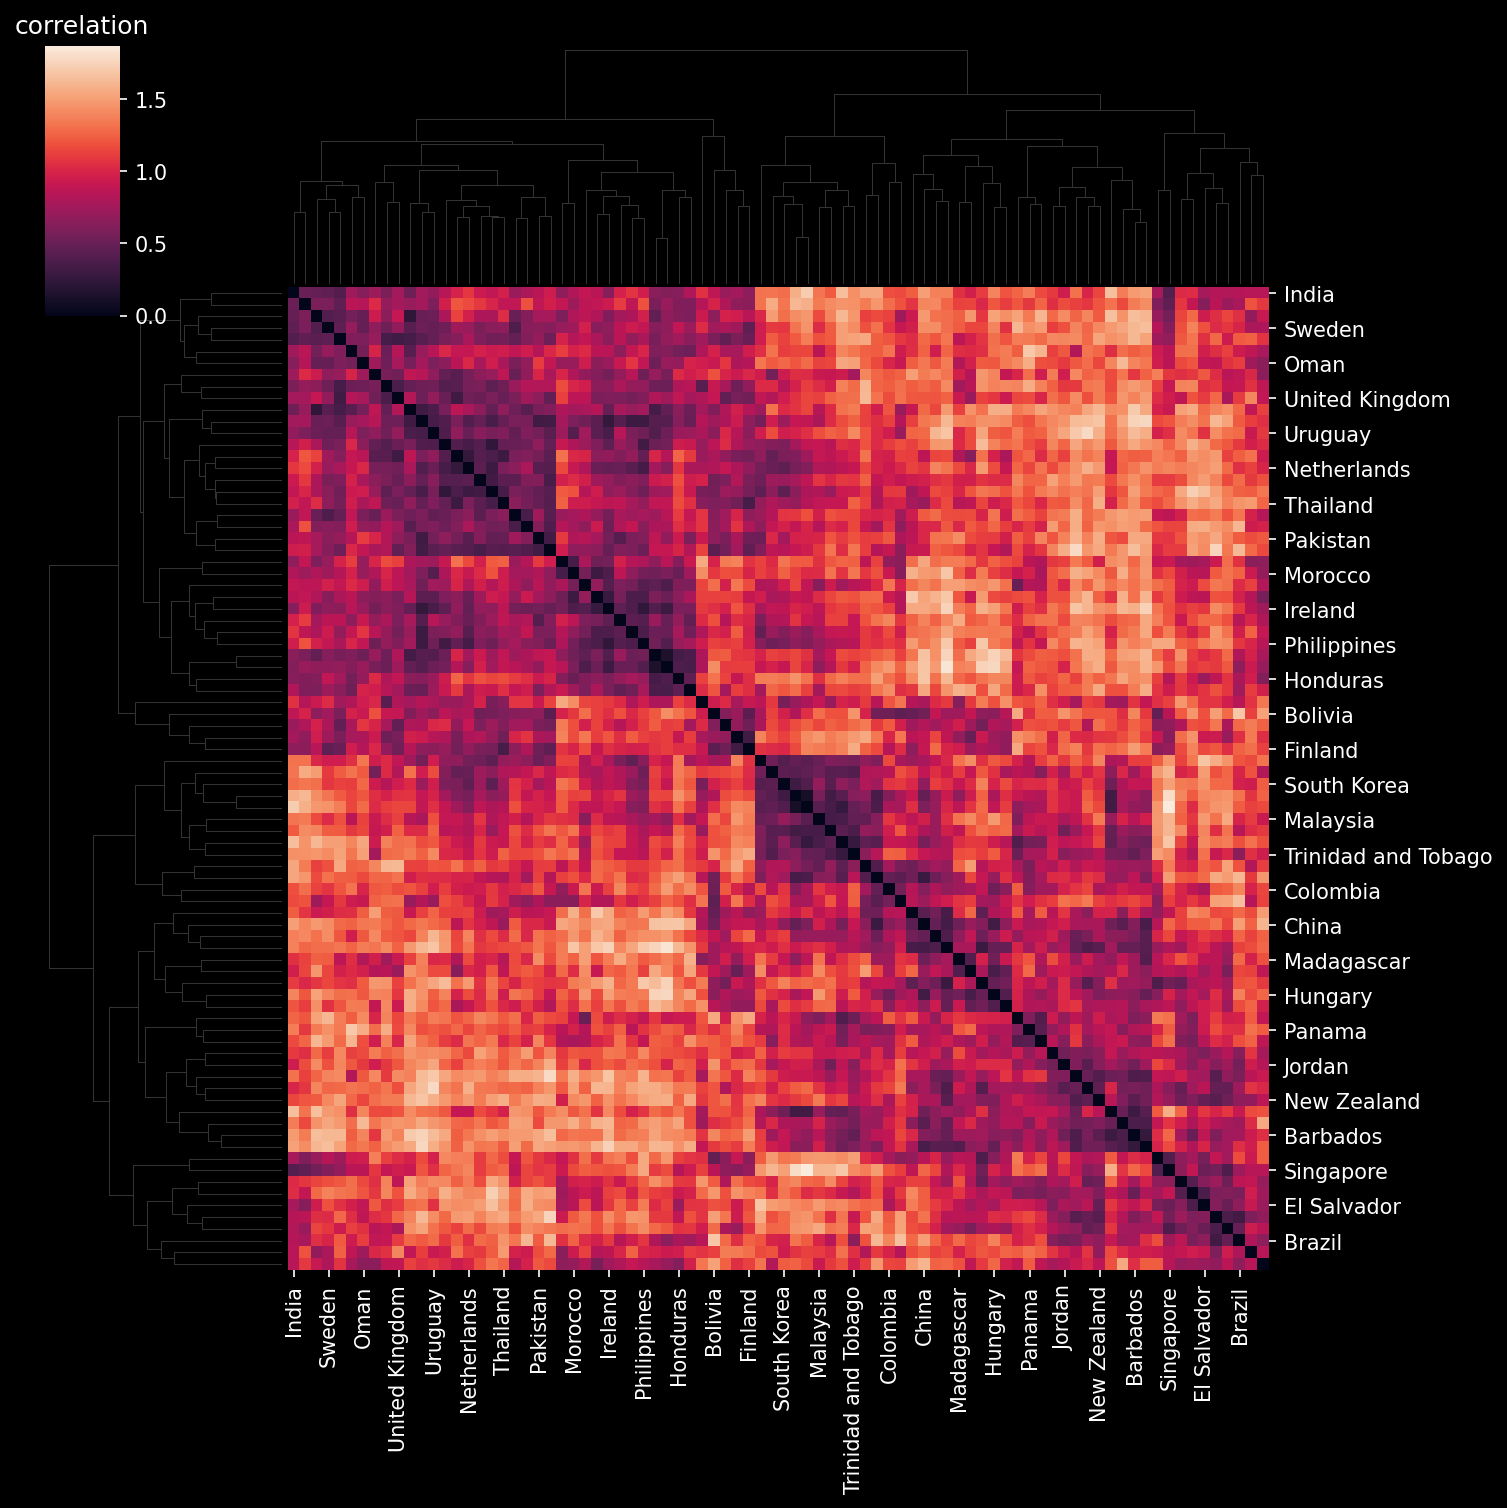

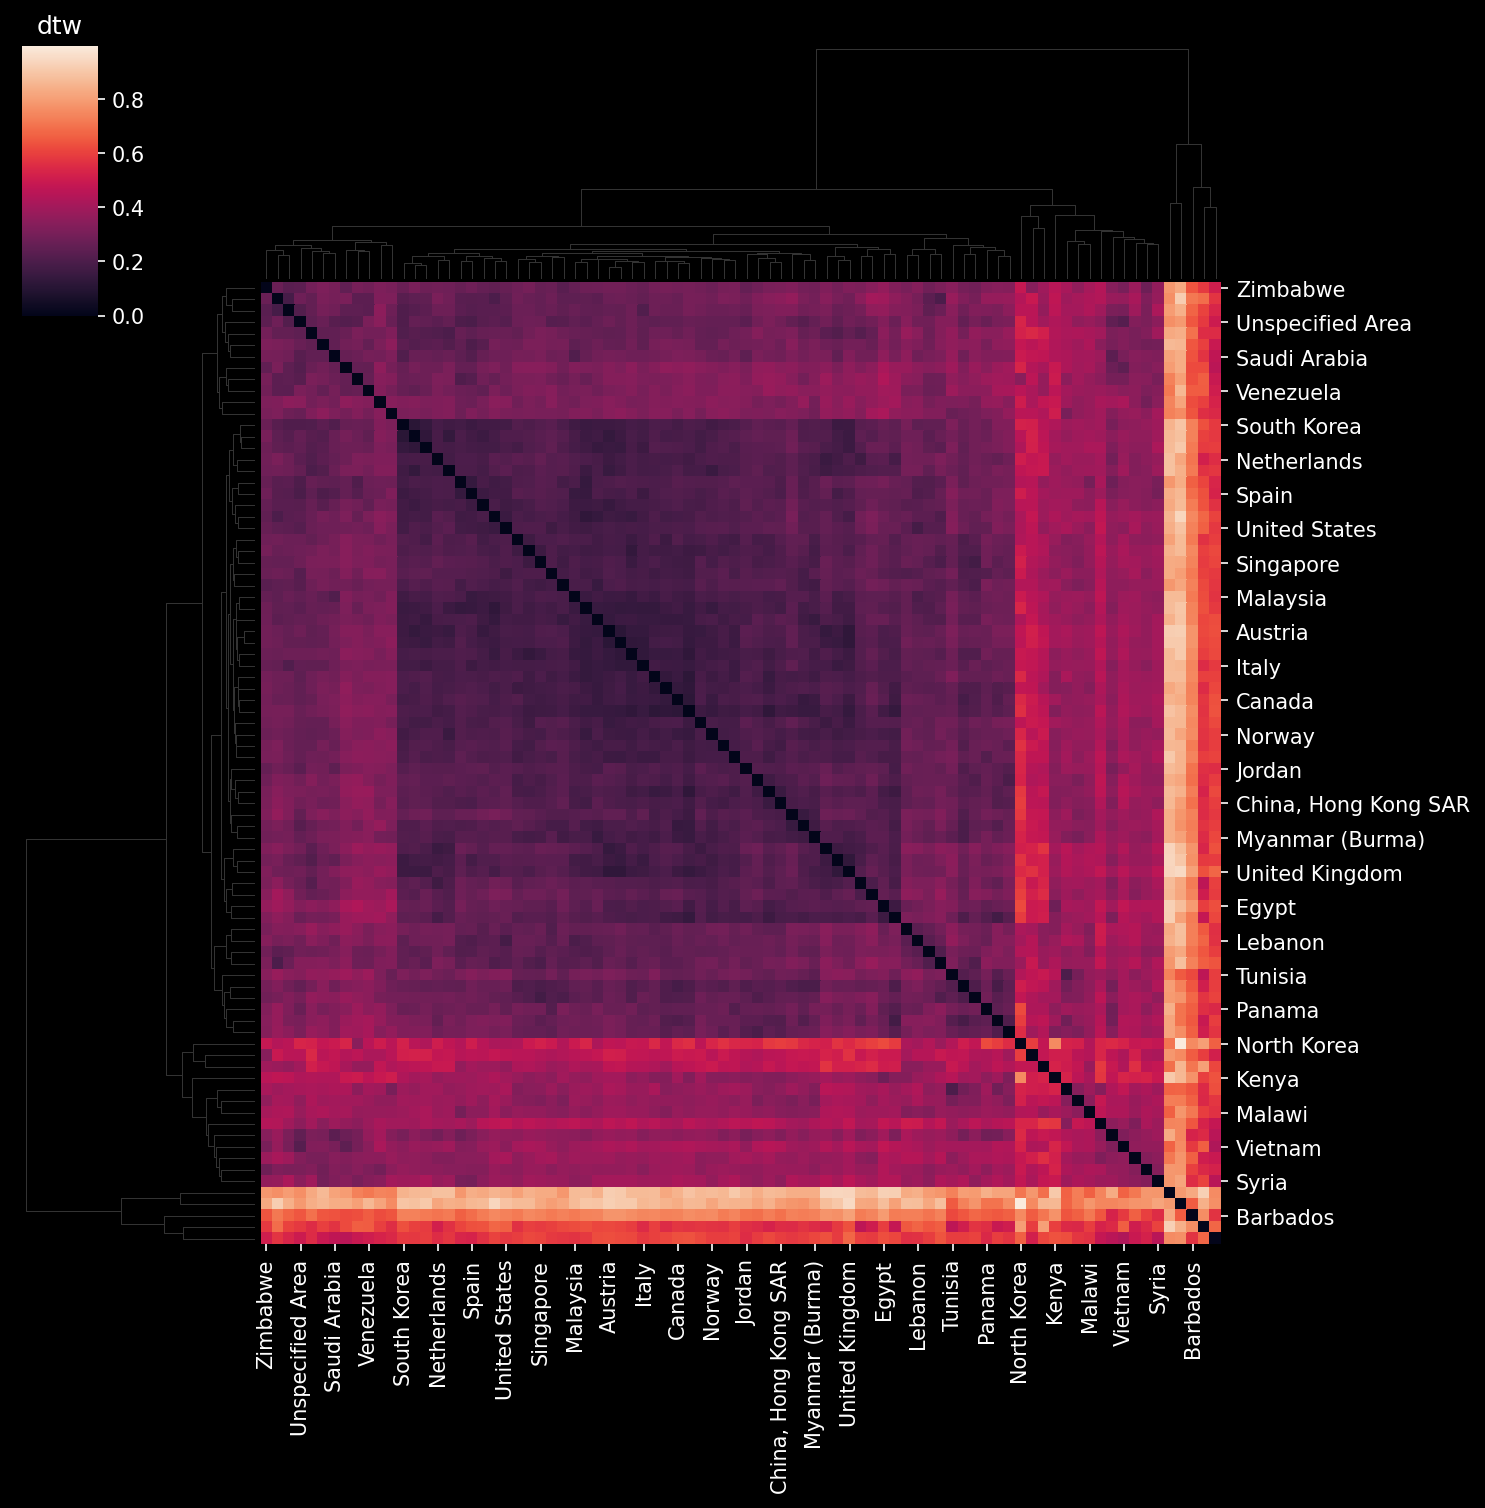

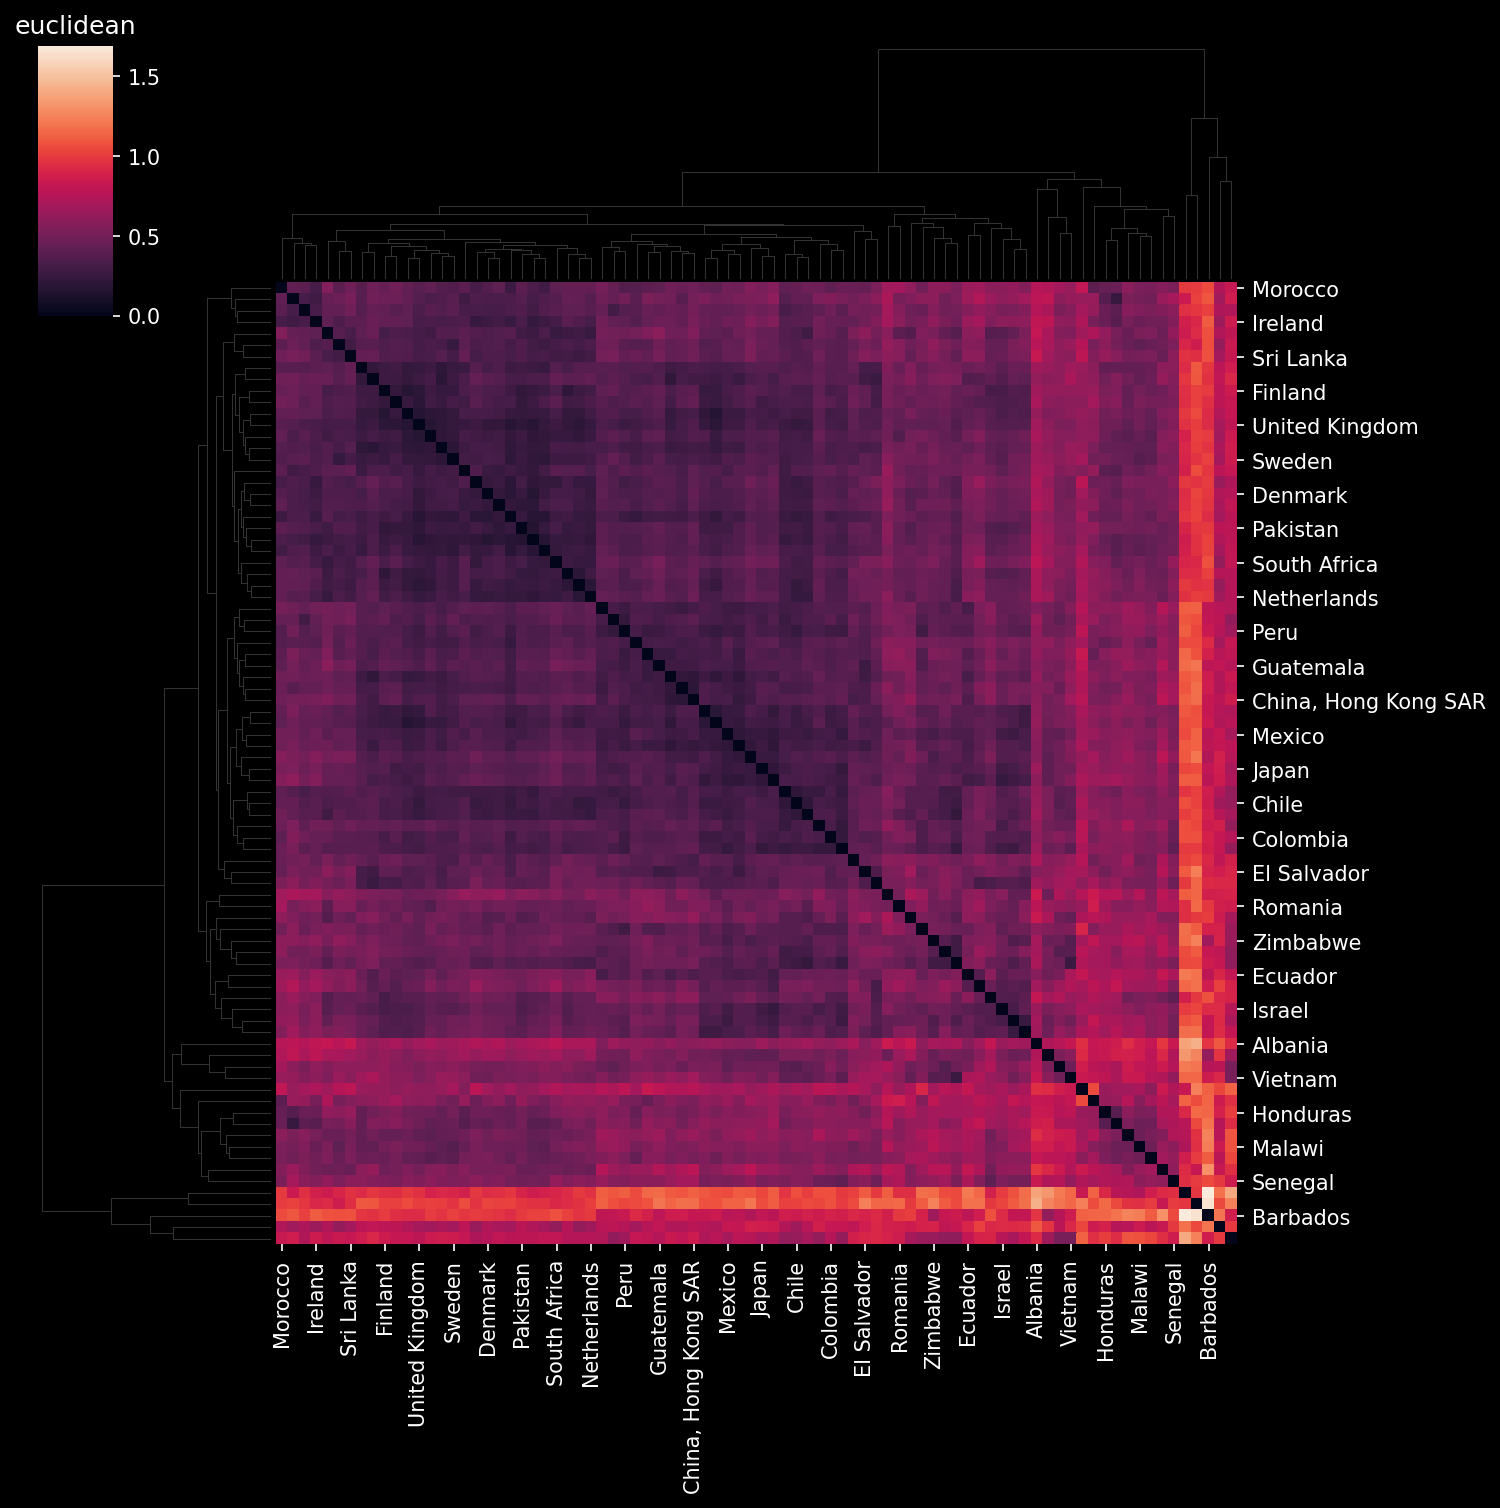

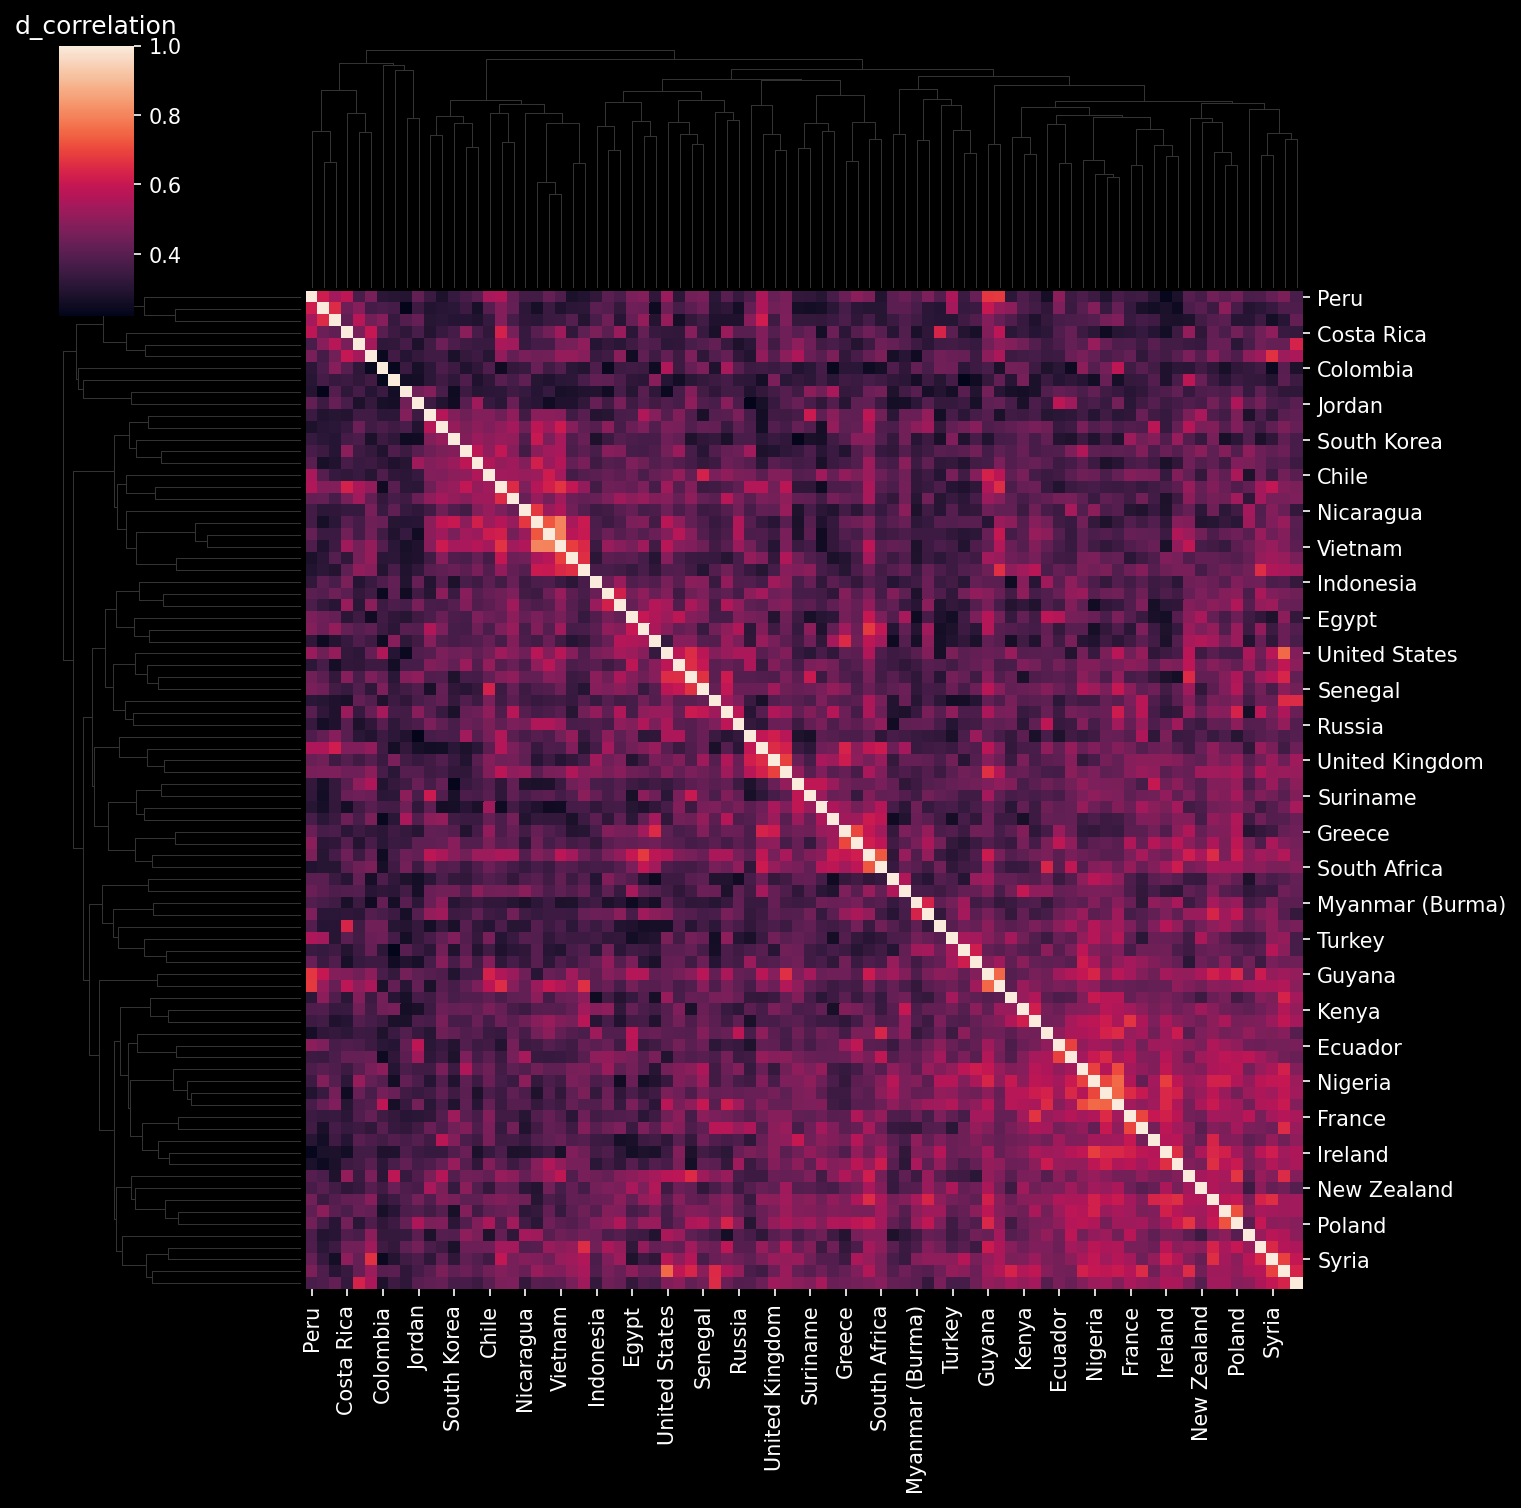

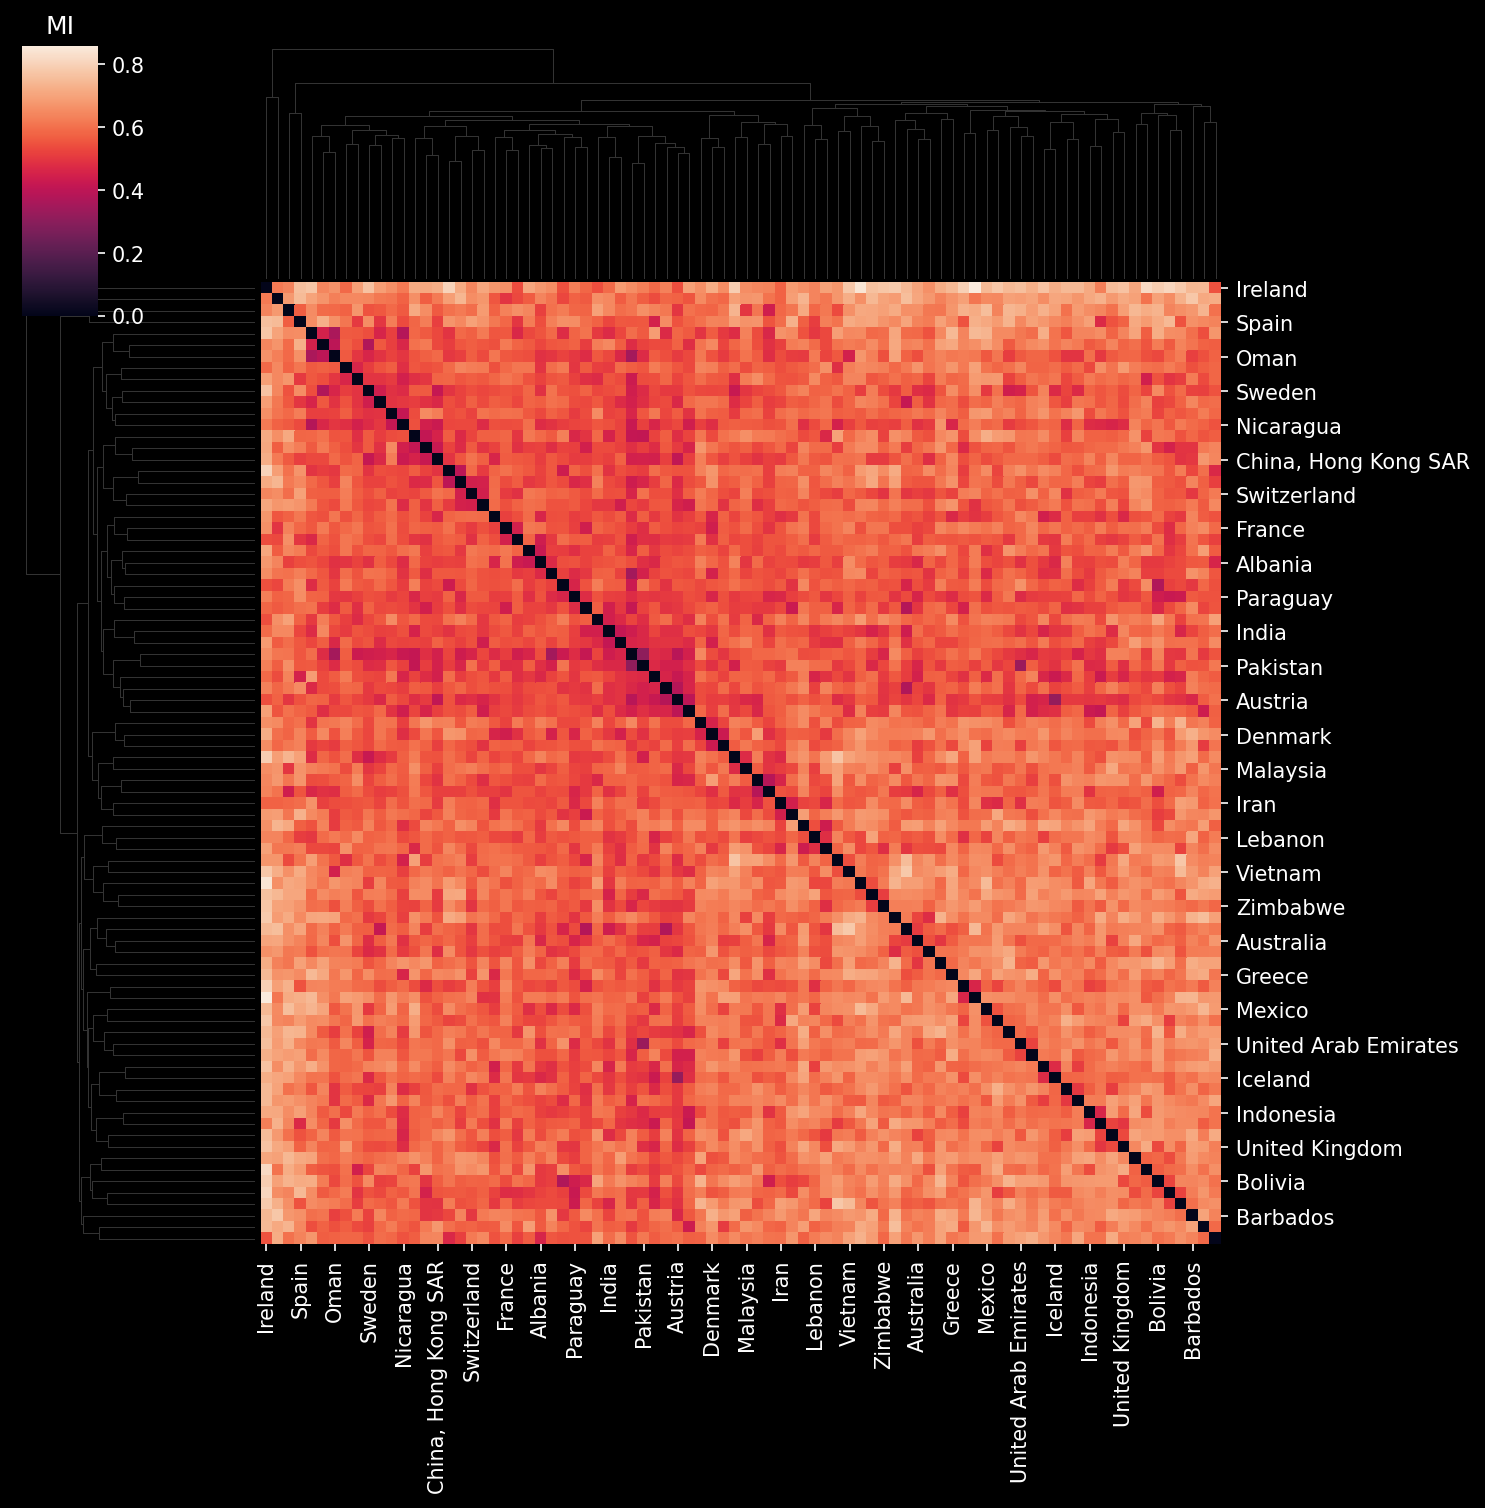

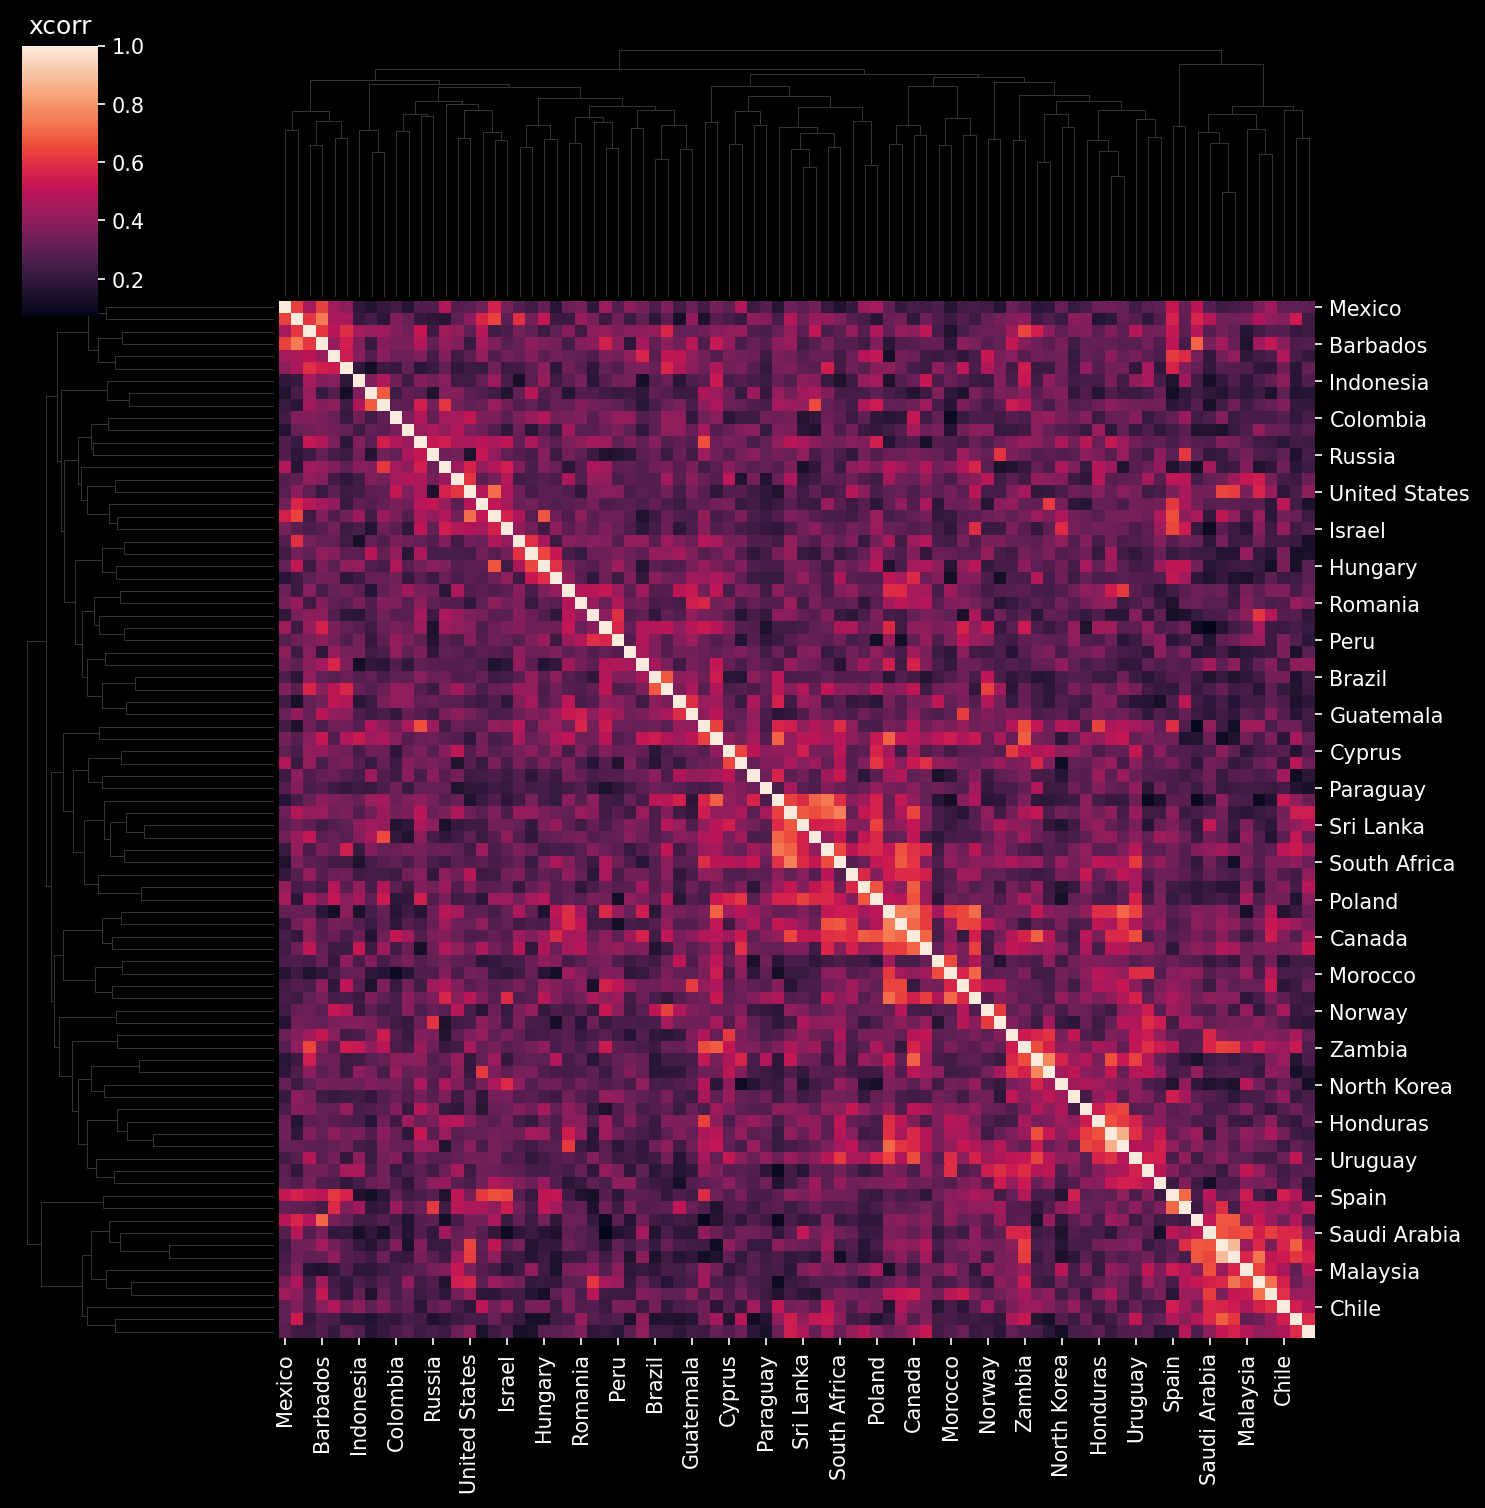

In [39]:
for elem in prox_matrices.items():
    dist_name,prox_matrix=elem
    linkage = hierarchy.linkage(prox_matrix,method='average')
    prox_df=pd.DataFrame(data=prox_matrix,index=mean_af_piv.index.values,columns=mean_af_piv.index.values)
    sns.clustermap(prox_df,row_linkage=linkage,col_linkage=linkage)
    plt.title(dist_name)

In [19]:
# prox_df=pd.DataFrame(data=prox_matrices['d_correlation'],index=mean_af_piv.index.values,columns=mean_af_piv.index.values)
prox_df=pd.DataFrame(data=prox_matrices['xcorr'],index=mean_af_piv.index.values,columns=mean_af_piv.index.values)

In [20]:
treshold=.65
connected_countries=prox_df[prox_df>treshold].fillna(0)
np.fill_diagonal(connected_countries.values,0)

In [21]:
import networkx as nx

In [116]:
G = nx.Graph()
for country1,series in connected_countries.iteritems():
    for country2,proximity in series.iteritems():
        if not np.equal(proximity,0):  
            G.add_edge(country1,country2,length=proximity)

In [117]:
countries=[]
degrees=[]
for country,degree in dict(nx.degree(G)).items():
    countries.append(country)
    degrees.append(degree)

In [118]:
X,Y=[],[]
distances=[]
for x,y,distance in G.edges(data=True):
    X.append(x)
    Y.append(y)
    distances.append(distance['length'])

In [119]:
country_proximity=pd.DataFrame({'c1':X,'c2':Y,'prox':distances})

In [120]:
sorted_proximity_countries=country_proximity.sort_values(by='prox',ascending=False)

In [121]:
sorted_proximity_countries.shape

(46, 3)

In [122]:
sorted_proximity_countries.iloc[:,:].tail(10)

,c1,c2,prox
38,Nigeria,Honduras,0.660518
5,Netherlands,Philippines,0.660384
32,China,Spain,0.658850
13,Bolivia,Switzerland,0.657606
24,Guyana,Nigeria,0.657327
40,Malaysia,Saudi Arabia,0.657011
22,Canada,Uruguay,0.655267
14,Switzerland,Zambia,0.653645
25,Guyana,Zambia,0.652959
3,Argentina,Thailand,0.652079


<AxesSubplot:xlabel='date'>

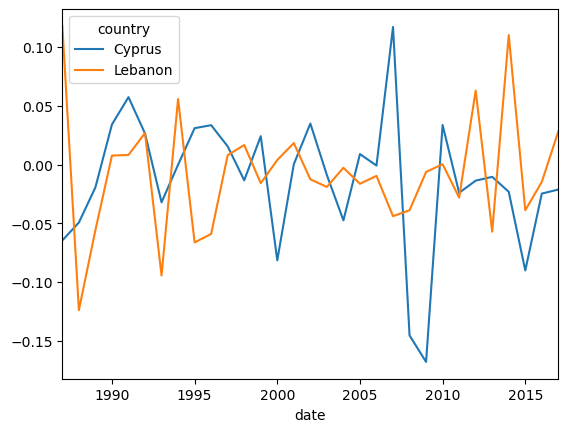

In [112]:
mean_af_piv.T[['Cyprus','Lebanon']].plot()

In [24]:
world=gdp.read_file('../../world_shapefiles/Longitude_Graticules_and_World_Countries_Boundaries-shp/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp')
world=world[world.CNTRY_NAME !='Antarctica']

In [25]:
world_meters=world.to_crs(epsg=32663)

In [26]:
from shapely.geometry import linestring

In [27]:
lines=[]
for country1,country2 in G.edges:
    try:
        centroid1=world_meters[world_meters['CNTRY_NAME']==country1].centroid.values[0]
        centroid2=world_meters[world_meters['CNTRY_NAME']==country2].centroid.values[0]
        lines.append( linestring.LineString([centroid1,centroid2]))
    except IndexError as e:
        pass
    
lines=gdp.GeoSeries(lines)

NameError: name 'G' is not defined

In [ ]:
max_prox_lines=[]
for i,row in enumerate(sorted_proximity_countries.iterrows()):
    try:
        centroid1=world_meters[world_meters['CNTRY_NAME']==row[1].c1].centroid.values[0]
        centroid2=world_meters[world_meters['CNTRY_NAME']==row[1].c2].centroid.values[0]
        max_prox_lines.append( linestring.LineString([centroid1,centroid2]))
    except IndexError as e:
        print(e)
    if i==11:
        break
max_prox_lines=gdp.GeoSeries(max_prox_lines)

In [ ]:
plt.style.use('default')

<AxesSubplot:>

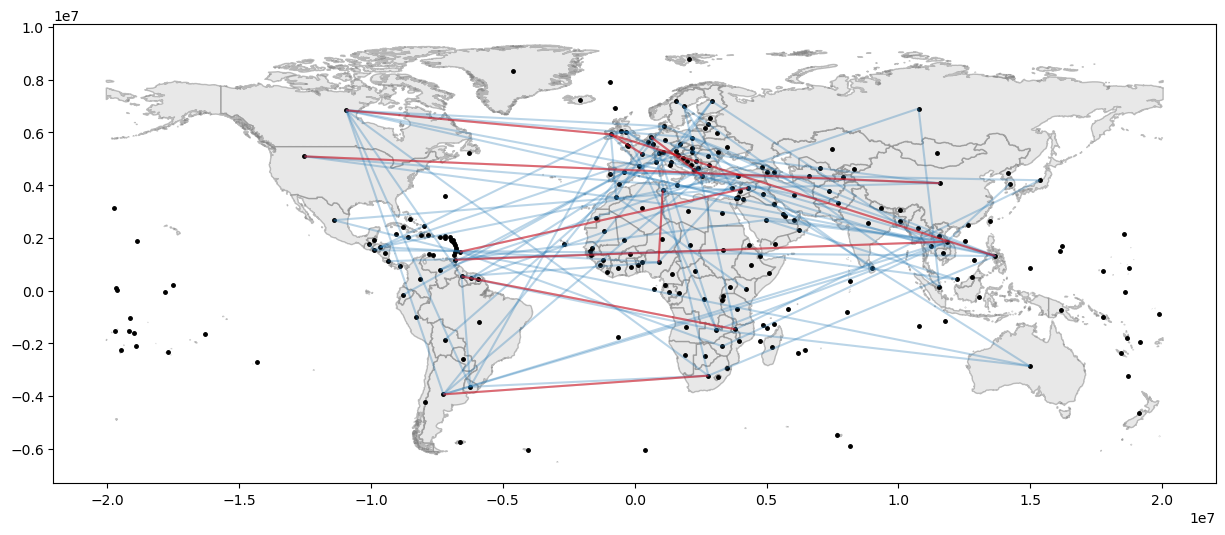

In [96]:
fig,ax=plt.subplots(figsize=(15,15)) #AF
world_meters.plot(color='lightgrey',
                      edgecolor='grey',
                      alpha=.5,
                      ax=ax)

centroids=world_meters.centroid

lines.plot(alpha=.3,ax=ax)
max_prox_lines.plot(color='red',ax=ax,alpha=.5)
centroids.plot(color='black',markersize=25,ax=ax,marker='.')

In [123]:
def get_areas(df):
    areas_diff=[]
    x,y=[],[]
    for element in df.iterrows():
        p1,p2=element[1].c1,element[1].c2
        try:
            areas_diff.append(abs(world_meters[world_meters.CNTRY_NAME==p1].area.values[0]/1e6 -
                             world_meters[world_meters.CNTRY_NAME==p2].area.values[0]/1e6))
            x.append(p1)
            y.append(p2)
        except IndexError as e:
            pass
    return x,y,areas_diff

In [124]:
def bubble_plot(x,y,areas):
    fig,ax=plt.subplots(figsize=(16,8))
    factor=(1e-3) * max(get_areas(sorted_proximity_countries)[-1])
    plt.scatter(x,y,s=np.array(areas)/(factor),alpha=.6)
    ax.grid()

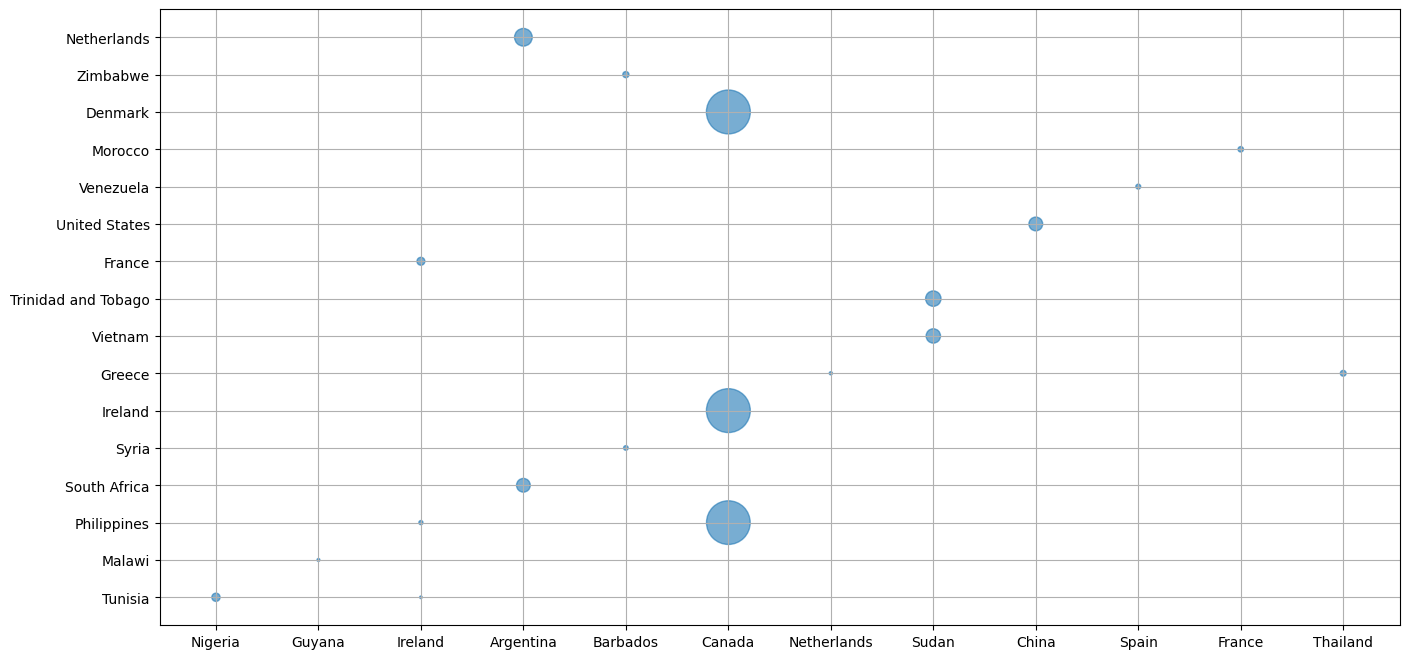

In [126]:
bubble_plot(*get_areas(sorted_proximity_countries.iloc[:20]))

In [22]:
sets={'af':mean_af,'gdp':mean_af_gdp,'pop':mean_af_population,'cal':mean_af_caloric}

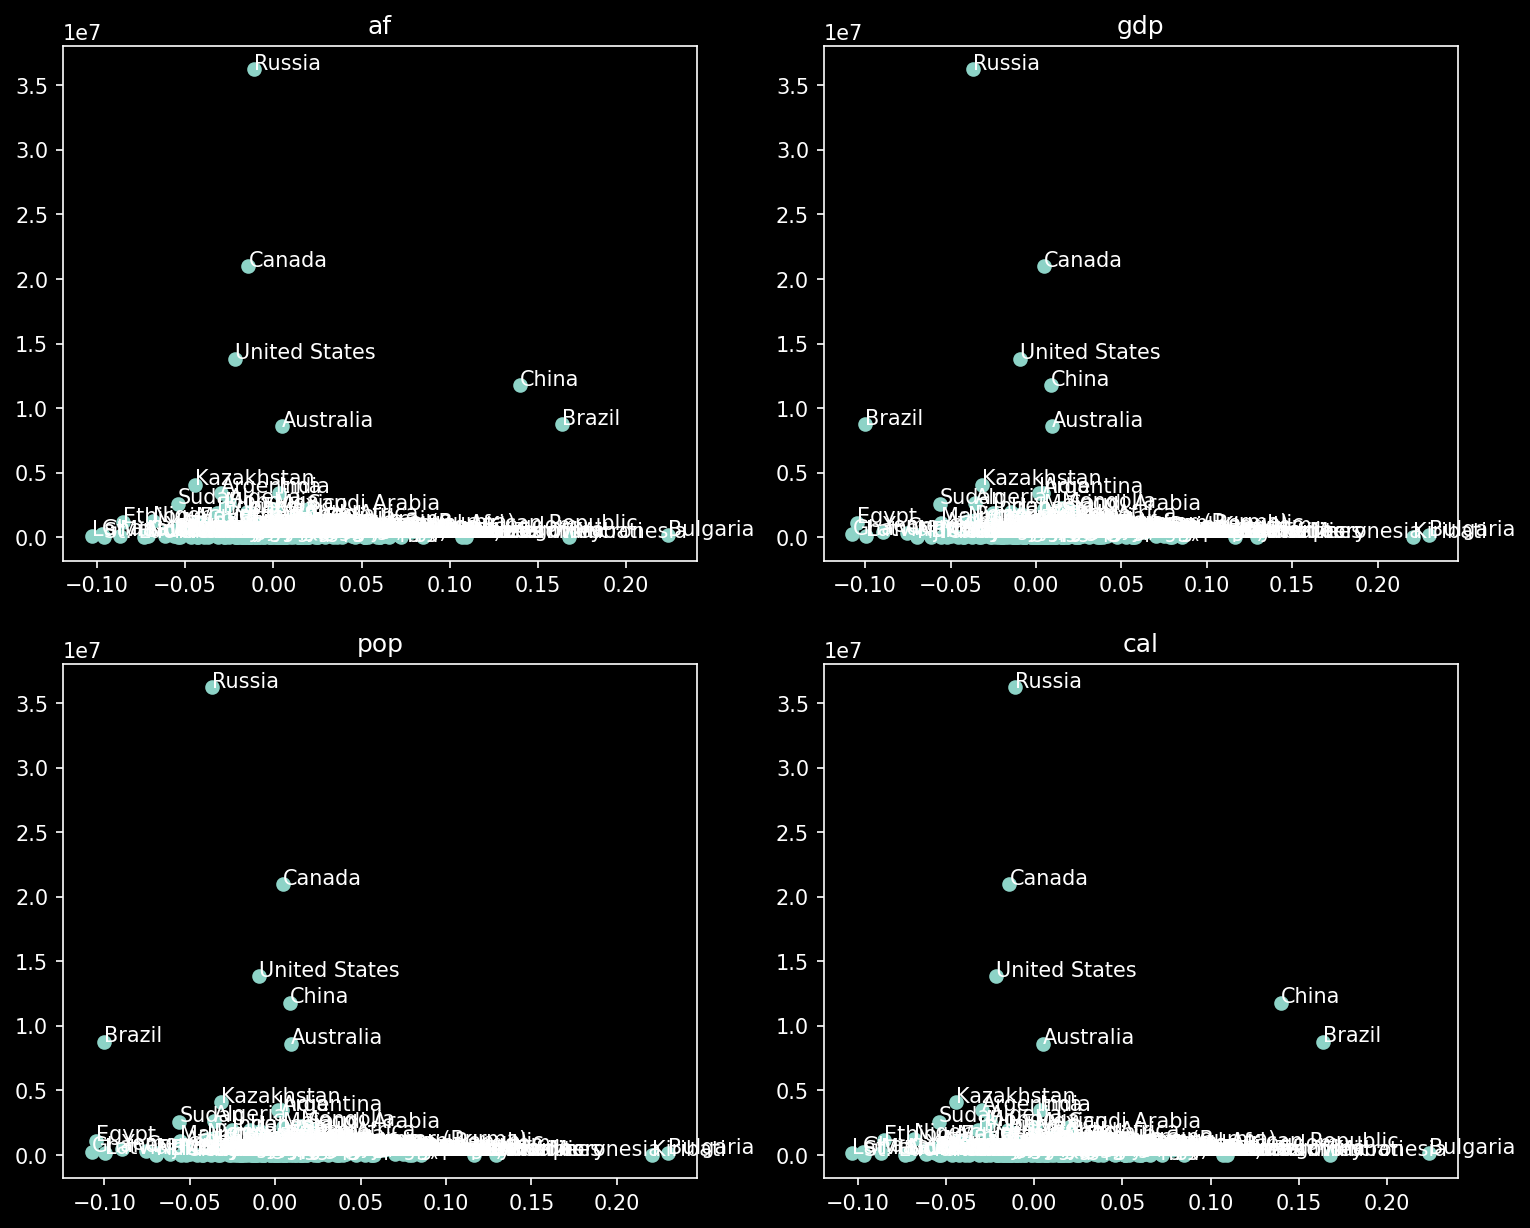

In [28]:
fig,axs=plt.subplots(2,2,figsize=(12,10))
axs=axs.flatten()
for i,tup in enumerate(sets.items()):
    name,dat=tup
    to_plot=dat
    tempporal=world_meters.merge(to_plot.reset_index(),left_on='CNTRY_NAME',right_on='country',how='inner')
    size_countries=pd.DataFrame({country:size for country,size in zip(tempporal.CNTRY_NAME,tempporal.area/1e6)},index=[0])
    test1=to_plot[to_plot.index.isin(size_countries.columns)].T
    test2=size_countries
    
    x,y=test1.mean(axis=0),test2.sum(axis=0)
    n=test2.columns
    axs[i].scatter(x,y)
#     axs[i].set_ylim(0,1e6)
#     axs[i].set_xlim(-.15,0)
    axs[i].set_title(name)
    for j, txt in enumerate(n):
        axs[i].annotate(txt, (x[j], y[j]))

In [21]:
def plot_scatter_time(country1,country2):
    fig, ax = plt.subplots()

    x = mean_af_piv.loc[country1].values
    y = mean_af_piv.loc[country2].values
    n = mean_af_piv.loc[country1].index.values

    ax.scatter(x,y)
    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i], y[i]))